In [1]:
# Install the torchmetrics package for storing loss, evaluation metrics, etc.
!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install torchsummary
!pip install torchviz
!pip install hiddenlayer
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

Link to the dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import zipfile
import random
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


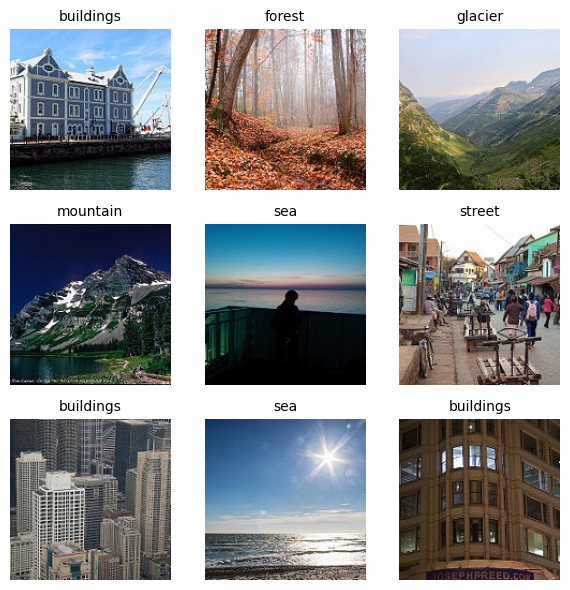

In [18]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# ✅ STEP 1: Define correct full dataset path for Kaggle
full_data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"

# ✅ STEP 2: Visualize 9 sample images from the dataset (one per class, plus randoms)
class_dirs = sorted(os.listdir(full_data_dir))  # class names: buildings, forest, etc.
samples = []

for cls in class_dirs:
    class_path = os.path.join(full_data_dir, cls)
    img_files = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    if img_files:
        img_path = os.path.join(class_path, random.choice(img_files))
        samples.append((img_path, cls))

while len(samples) < 9:
    cls = random.choice(class_dirs)
    class_path = os.path.join(full_data_dir, cls)
    img_files = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    img_path = os.path.join(class_path, random.choice(img_files))
    samples.append((img_path, cls))

plt.figure(figsize=(6, 6))
for idx, (img_path, label) in enumerate(samples):
    image = Image.open(img_path).convert("RGB")
    plt.subplot(3, 3, idx + 1)
    plt.imshow(image)
    plt.title(label, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [19]:
# Path to the main training data directory
data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"

# Define transformations to apply to training images (i.e., data augmentation + preprocessing)
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),                    # Resize all images
    transforms.RandomHorizontalFlip(),                # Randomly flip images horizontally
    transforms.RandomRotation(15),                    # Randomly rotate images within ±15 degrees
    transforms.ColorJitter(brightness=0.2,            # Randomly change brightness
                           contrast=0.2,              # Randomly change contrast
                           saturation=0.2),           # Randomly change saturation
    transforms.ToTensor(),                            # Convert image to PyTorch tensor (HWC → CHW)
    transforms.Normalize([0.5]*3, [0.5]*3)            # Normalize tensor values to range [-1, 1]
])

# Define transformations for validation and test sets (only resize + normalize, no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),                    # Resize to same shape as training images
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)            # Normalize tensor values
])

# Load entire dataset from the directory using the training transform (augmentations)
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
# Get the class names from the folder structure
class_names = full_dataset.classes

# Split the dataset into train (60%), validation (20%), and test (20%) subsets
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Override transforms for validation and test sets (remove augmentation)
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
val_set.dataset.transform = test_transform
test_set.dataset.transform = test_transform

# Create DataLoaders for each subset
# - batch_size=32: load 32 images per batch
# - shuffle=True for training to improve generalization
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [20]:
# Confirm
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train: 8420 | Val: 2806 | Test: 2808


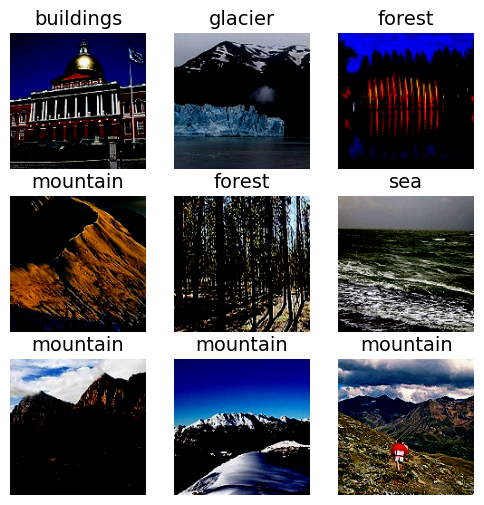

In [21]:
# Show 9 samples with class labels
plt.figure(figsize=(6, 6))
for i in range(9):
    image, label = train_set[i]  # Index into train_dataset
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # CHW -> HWC
    plt.title(class_names[label],fontsize=14)  # Use the actual label name
    plt.axis('off')

# plt.tight_layout()
plt.show()

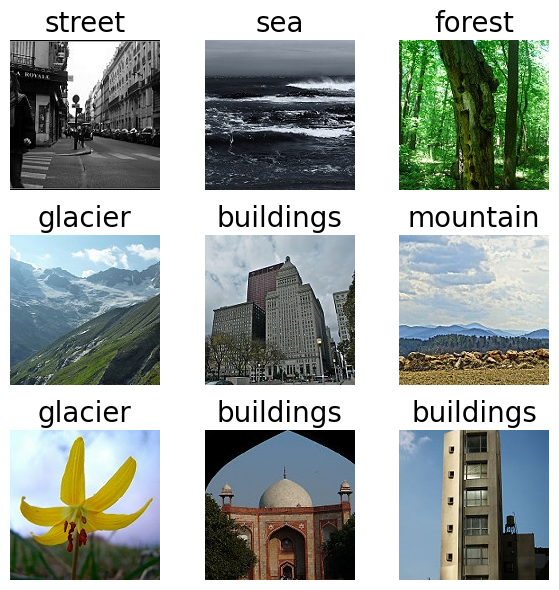

In [22]:
import torch
import matplotlib.pyplot as plt

# Helper: Unnormalize image
def unnormalize(img_tensor):
    img = img_tensor.clone()
    img = img * 0.5 + 0.5  # Undo Normalize([0.5]*3, [0.5]*3)
    return img

# Step 1: Collect at least one augmented image per class
seen_classes = set()
samples = []

# Use DataLoader to get augmented images
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_idx = label.item()
        if class_idx not in seen_classes:
            samples.append((img, class_names[class_idx]))
            seen_classes.add(class_idx)
        if len(seen_classes) == len(class_names):
            break
    if len(seen_classes) == len(class_names):
        break

# Step 2: Add random images from train_loader to make total 9
while len(samples) < 9:
    for images, labels in train_loader:
        for img, label in zip(images, labels):
            samples.append((img, class_names[label.item()]))
            if len(samples) == 9:
                break
        if len(samples) == 9:
            break

# Step 3: Plot 3×3 Grid
plt.figure(figsize=(6, 6))
for idx, (img, label) in enumerate(samples):
    img = unnormalize(img)
    plt.subplot(3, 3, idx + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label, fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Define Custom CNN

In [31]:
# Define a custom CNN model for image classification

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()

        # Feature extraction layers (convolutional blocks)
        self.features = nn.Sequential(
            # First block: Conv → ReLU → Conv → ReLU → BatchNorm → MaxPool
            nn.Conv2d(3, 16, kernel_size=3),    # Input: 3 channels (RGB), Output: 16 feature maps
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3),   # Deeper features with same output channels
            nn.ReLU(),
            nn.BatchNorm2d(16),                 # Normalize feature maps
            nn.MaxPool2d(3),                    # Downsample spatial dimensions

            # Second block
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            # Third block
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            # Fourth block
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            # Fifth block with padding to preserve dimensions
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)                    # Regularization to prevent overfitting
        )

        # Flatten dimension after all pooling layers (assumes input image is 150x150)
        self.flatten_dim = 256 * 2 * 2

        # Fully connected classification layers
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.25),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.4),

            # Final output layer (e.g., 6 classes)
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
      # Apply convolutional layers
      x = self.features(x)
      # Flatten tensor (keep batch dimension)
      x = torch.flatten(x, 1)
      # Pass through fully connected layers
      return self.classifier(x)


In [24]:
from torchsummary import summary

# Instantiate your model
model = CustomCNN(num_classes=6).to(device)

# Print model summary with input size (e.g. for RGB image 150x150)
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]             448
              ReLU-2         [-1, 16, 148, 148]               0
            Conv2d-3         [-1, 16, 146, 146]           2,320
              ReLU-4         [-1, 16, 146, 146]               0
       BatchNorm2d-5         [-1, 16, 146, 146]              32
         MaxPool2d-6           [-1, 16, 48, 48]               0
            Conv2d-7           [-1, 32, 46, 46]           4,640
              ReLU-8           [-1, 32, 46, 46]               0
            Conv2d-9           [-1, 32, 44, 44]           9,248
             ReLU-10           [-1, 32, 44, 44]               0
      BatchNorm2d-11           [-1, 32, 44, 44]              64
        MaxPool2d-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 64, 20, 20]          18,496
             ReLU-14           [-1, 64,

In [25]:
print(model)

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [26]:
# # Step 4: Train the Model
# train_losses = []
# val_losses = []

# import time

# model = CustomCNN(num_classes=len(class_names)).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# start_time = time.time()  # Start total timing

# for epoch in range(15):
#     model.train()
#     total, correct, train_loss_sum = 0, 0, 0.0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss_sum += loss.item()
#         _, preds = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (preds == labels).sum().item()

#     train_acc = 100 * correct / total
#     avg_train_loss = train_loss_sum / len(train_loader)

#     # Validation
#     model.eval()
#     val_total, val_correct, val_loss_sum = 0, 0, 0.0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss_sum += loss.item()
#             _, preds = torch.max(outputs, 1)
#             val_total += labels.size(0)
#             val_correct += (preds == labels).sum().item()

#     val_acc = 100 * val_correct / val_total
#     avg_val_loss = val_loss_sum / len(val_loader)

#     # Validation
#     train_losses.append(avg_train_loss)
#     val_losses.append(avg_val_loss)

#     print(f"Epoch {epoch+1:02d} | "
#           f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
#           f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# total_time = time.time() - start_time
# print(f"\nTotal training time for CustomCNN: {total_time:.2f} seconds")


KeyboardInterrupt: 

In [79]:
# ===  NEW  ===

# Step 4: Train the Model
train_losses = []
val_losses = []
test_losses = []
test_accuracies = []

import time

model = CustomCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

start_time = time.time()  # Start total timing

for epoch in range(15):
    model.train()
    total, correct, train_loss_sum = 0, 0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = train_loss_sum / len(train_loader)

    # Validation
    model.eval()
    val_total, val_correct, val_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss_sum / len(val_loader)

    # Test evaluation (NEW)
    test_total, test_correct, test_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    avg_test_loss = test_loss_sum / len(test_loader)

    # Store all losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    # Print metrics for this epoch
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# Total training time
total_time = time.time() - start_time
print(f"\nTotal training time for CustomCNN: {total_time:.2f} seconds")


Epoch 01 | Train Loss: 1.8910 | Train Acc: 21.35% | Val Loss: 1.6681 | Val Acc: 27.90% | Test Loss: 1.6663 | Test Acc: 28.67%
Epoch 02 | Train Loss: 1.7554 | Train Acc: 25.65% | Val Loss: 1.5697 | Val Acc: 36.81% | Test Loss: 1.5829 | Test Acc: 36.32%
Epoch 03 | Train Loss: 1.6605 | Train Acc: 29.07% | Val Loss: 1.5140 | Val Acc: 41.30% | Test Loss: 1.5276 | Test Acc: 40.56%
Epoch 04 | Train Loss: 1.5715 | Train Acc: 34.48% | Val Loss: 1.4258 | Val Acc: 46.90% | Test Loss: 1.4396 | Test Acc: 45.55%
Epoch 05 | Train Loss: 1.4713 | Train Acc: 40.71% | Val Loss: 1.3201 | Val Acc: 53.21% | Test Loss: 1.3436 | Test Acc: 50.43%
Epoch 06 | Train Loss: 1.4234 | Train Acc: 40.64% | Val Loss: 1.2660 | Val Acc: 55.24% | Test Loss: 1.2819 | Test Acc: 52.92%
Epoch 07 | Train Loss: 1.3517 | Train Acc: 45.99% | Val Loss: 1.1819 | Val Acc: 58.16% | Test Loss: 1.1999 | Test Acc: 56.30%
Epoch 08 | Train Loss: 1.3145 | Train Acc: 47.41% | Val Loss: 1.1635 | Val Acc: 57.84% | Test Loss: 1.1777 | Test Acc:

In [80]:
# Step 5A: Get Predictions & Probabilities
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

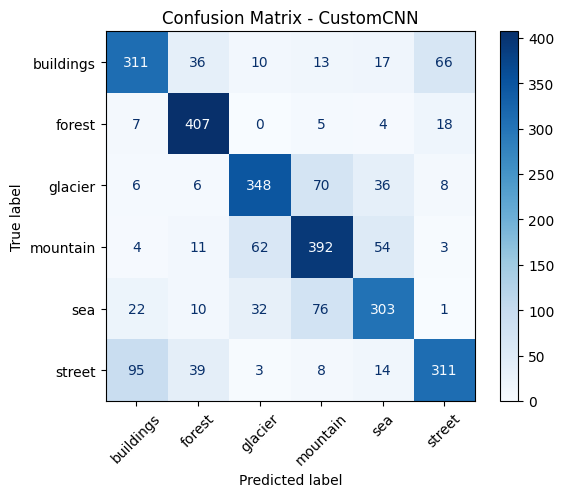

In [81]:
# Step 5B: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - CustomCNN")
plt.grid(False)
plt.show()

In [82]:
# Step 5C: Classification Report
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report as a dictionary
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round values for readability
report_df = report_df.round(2)

# Display the DataFrame
print("Classification Report (DataFrame Format):")
display(report_df)


Classification Report (DataFrame Format):


precision  recall  f1-score  support
buildings          0.70    0.69      0.69   453.00
forest             0.80    0.92      0.86   441.00
glacier            0.76    0.73      0.75   474.00
mountain           0.70    0.75      0.72   526.00
sea                0.71    0.68      0.69   444.00
street             0.76    0.66      0.71   470.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.74    0.74      0.74  2808.00
weighted avg       0.74    0.74      0.74  2808.00

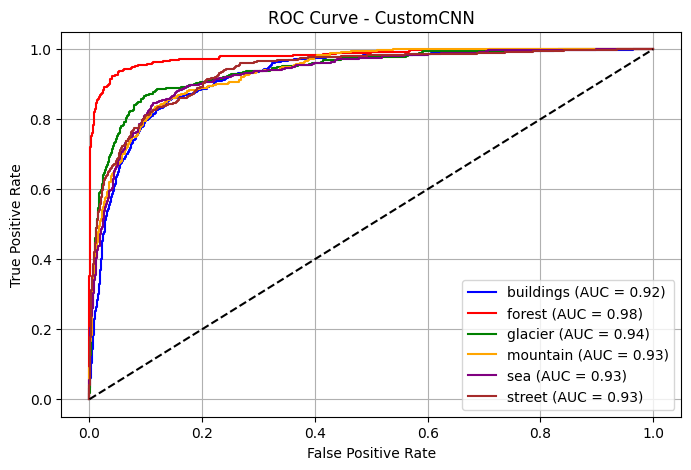

In [83]:
# Step 5D: ROC-AUC Curve
y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 5))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CustomCNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


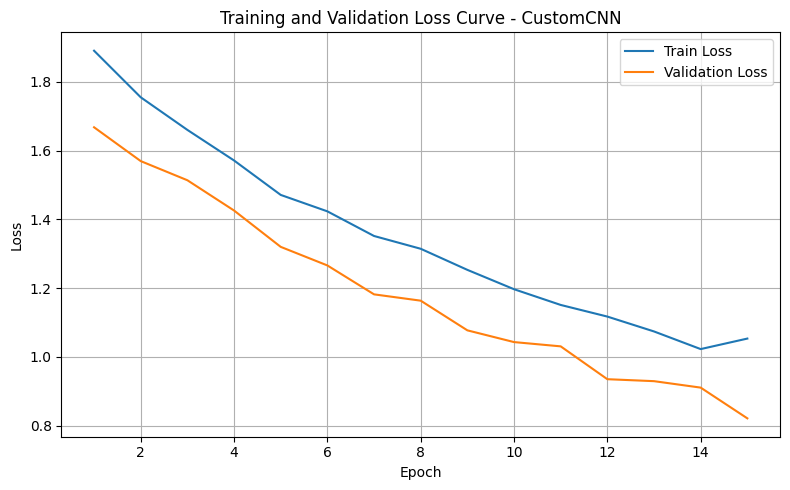

In [84]:
# Loss Curve

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve - CustomCNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Define MobileNetV2 Models

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import cycle
import time
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_loss_curves = {}

from torchvision.models import mobilenet_v2

# Step 1: Load model without weights
model = mobilenet_v2(weights=None)

# Step 2: Load the weights manually
state_dict = torch.load("/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth")
model.load_state_dict(state_dict)


<All keys matched successfully>

In [86]:
activation_functions = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Softsign": nn.Softsign()
}

In [77]:
# ---- ReLU ----

In [63]:
# # Define the exact model setup using your original hyperparameters and logic

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import mobilenet_v2
# import gc

# # Define model using uploaded weights, no changes to hyperparameters or classifier
# class CustomMobileNetV2(nn.Module):
#     def __init__(self, num_classes, weights_path):
#         super().__init__()
#         base_model = mobilenet_v2(weights=None)
#         state_dict = torch.load(weights_path, map_location='cpu')
#         base_model.load_state_dict(state_dict)
#         for param in base_model.features.parameters():
#             param.requires_grad = False
#         self.features = base_model.features
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(base_model.last_channel, 128),
#             nn.ReLU(),  # Replace with Tanh or Softsign for other experiments
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.mean([2, 3])  # Global average pooling
#         return self.classifier(x)

# # Train function exactly like your original setup
# def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15):
#     train_losses = []
#     val_losses = []
#     start_time = time.time()

#     for epoch in range(epochs):
#         gc.collect()
#         torch.cuda.empty_cache()

#         model.train()
#         total, correct, train_loss_sum = 0, 0, 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss_sum += loss.item()
#             _, preds = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (preds == labels).sum().item()

#         train_acc = 100 * correct / total
#         avg_train_loss = train_loss_sum / len(train_loader)

#         model.eval()
#         val_total, val_correct, val_loss_sum = 0, 0, 0.0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss_sum += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 val_total += labels.size(0)
#                 val_correct += (preds == labels).sum().item()

#         val_acc = 100 * val_correct / val_total
#         avg_val_loss = val_loss_sum / len(val_loader)

#         train_losses.append(avg_train_loss)
#         val_losses.append(avg_val_loss)

#         print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
#               f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

#     total_time = time.time() - start_time
#     print(f"\nTotal training time for MobileNetV2 with ReLU: {total_time:.2f} seconds")

#     return model, train_losses, val_losses


In [65]:
# # 1. Set paths and model
# weights_path = "/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth"  # ← change this to match your upload location
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CustomMobileNetV2(num_classes=6, weights_path=weights_path).to(device)

# # 2. Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# # 3. Train the model
# model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)


Epoch 01 | Train Loss: 0.8981 | Train Acc: 76.07% | Val Loss: 0.4701 | Val Acc: 87.24%
Epoch 02 | Train Loss: 0.4441 | Train Acc: 86.22% | Val Loss: 0.3662 | Val Acc: 87.88%
Epoch 03 | Train Loss: 0.3813 | Train Acc: 87.74% | Val Loss: 0.3348 | Val Acc: 88.63%
Epoch 04 | Train Loss: 0.3587 | Train Acc: 87.55% | Val Loss: 0.3225 | Val Acc: 88.92%
Epoch 05 | Train Loss: 0.3460 | Train Acc: 87.91% | Val Loss: 0.3372 | Val Acc: 87.70%
Epoch 06 | Train Loss: 0.3347 | Train Acc: 88.43% | Val Loss: 0.3077 | Val Acc: 89.31%
Epoch 07 | Train Loss: 0.3261 | Train Acc: 88.38% | Val Loss: 0.3030 | Val Acc: 89.09%
Epoch 08 | Train Loss: 0.3144 | Train Acc: 88.84% | Val Loss: 0.3108 | Val Acc: 88.60%
Epoch 09 | Train Loss: 0.3123 | Train Acc: 89.05% | Val Loss: 0.3031 | Val Acc: 88.88%
Epoch 10 | Train Loss: 0.3085 | Train Acc: 88.85% | Val Loss: 0.3154 | Val Acc: 88.24%
Epoch 11 | Train Loss: 0.2945 | Train Acc: 89.45% | Val Loss: 0.3062 | Val Acc: 89.02%
Epoch 12 | Train Loss: 0.2985 | Train Acc: 

In [87]:
# ==== NEW ====

# Define the exact model setup using your original hyperparameters and logic

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
import gc

# Define model using uploaded weights, no changes to hyperparameters or classifier
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, weights_path):
        super().__init__()
        base_model = mobilenet_v2(weights=None)
        state_dict = torch.load(weights_path, map_location='cpu')
        base_model.load_state_dict(state_dict)
        for param in base_model.features.parameters():
            param.requires_grad = False
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(base_model.last_channel, 128),
            nn.ReLU(),  # Replace with Tanh or Softsign for other experiments
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        return self.classifier(x)

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs=15):
    train_losses = []
    val_losses = []
    test_losses = []
    test_accuracies = []

    import time
    start_time = time.time()

    for epoch in range(epochs):
        gc.collect()
        torch.cuda.empty_cache()

        # === Training ===
        model.train()
        total, correct, train_loss_sum = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total
        avg_train_loss = train_loss_sum / len(train_loader)

        # === Validation ===
        model.eval()
        val_total, val_correct, val_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss_sum / len(val_loader)

        # === Test Evaluation ===
        test_total, test_correct, test_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (preds == labels).sum().item()

        test_acc = 100 * test_correct / test_total
        avg_test_loss = test_loss_sum / len(test_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)

        # === Print All Metrics Per Epoch ===
        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTotal training time for MobileNetV2 with ReLU: {total_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, test_accuracies


In [88]:
# 1. Set paths and model
weights_path = "/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth"  # adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomMobileNetV2(num_classes=6, weights_path=weights_path).to(device)

# 2. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# 3. Train the model (now with test evaluation)
model, train_losses, val_losses, test_losses, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, device)
# After training Tanh model
Relu_train_losses = train_losses
Relu_val_losses = val_losses

Epoch 01 | Train Loss: 0.8843 | Train Acc: 76.46% | Val Loss: 0.4333 | Val Acc: 88.45% | Test Loss: 0.4384 | Test Acc: 87.86%
Epoch 02 | Train Loss: 0.4409 | Train Acc: 86.07% | Val Loss: 0.3413 | Val Acc: 89.20% | Test Loss: 0.3509 | Test Acc: 88.75%
Epoch 03 | Train Loss: 0.3902 | Train Acc: 86.83% | Val Loss: 0.3157 | Val Acc: 88.95% | Test Loss: 0.3271 | Test Acc: 88.68%
Epoch 04 | Train Loss: 0.3611 | Train Acc: 87.29% | Val Loss: 0.3100 | Val Acc: 89.02% | Test Loss: 0.3356 | Test Acc: 88.28%
Epoch 05 | Train Loss: 0.3533 | Train Acc: 87.52% | Val Loss: 0.2911 | Val Acc: 89.52% | Test Loss: 0.3118 | Test Acc: 89.39%
Epoch 06 | Train Loss: 0.3402 | Train Acc: 87.99% | Val Loss: 0.2848 | Val Acc: 89.74% | Test Loss: 0.3122 | Test Acc: 89.35%
Epoch 07 | Train Loss: 0.3351 | Train Acc: 88.06% | Val Loss: 0.2866 | Val Acc: 89.84% | Test Loss: 0.3103 | Test Acc: 89.49%
Epoch 08 | Train Loss: 0.3247 | Train Acc: 88.30% | Val Loss: 0.2818 | Val Acc: 90.06% | Test Loss: 0.3104 | Test Acc:

In [107]:
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


In [83]:
# classification_report

In [92]:
from sklearn.metrics import classification_report
import pandas as pd

# If not already defined:
# class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df_ReLU = pd.DataFrame(report).transpose().round(2)
report_df_ReLU


precision  recall  f1-score  support
buildings          0.89    0.91      0.90   453.00
forest             0.98    0.98      0.98   441.00
glacier            0.84    0.80      0.82   474.00
mountain           0.86    0.81      0.83   526.00
sea                0.85    0.94      0.89   444.00
street             0.91    0.91      0.91   470.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.89    0.89      0.89  2808.00
weighted avg       0.89    0.89      0.89  2808.00

In [ ]:
# ConfusionMatrix

<Figure size 800x600 with 0 Axes>

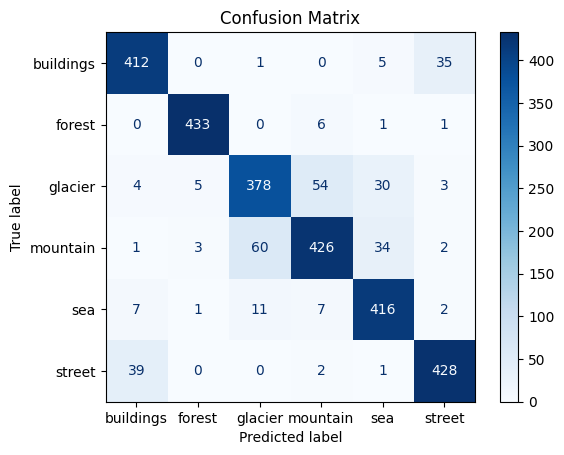

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ROC plot

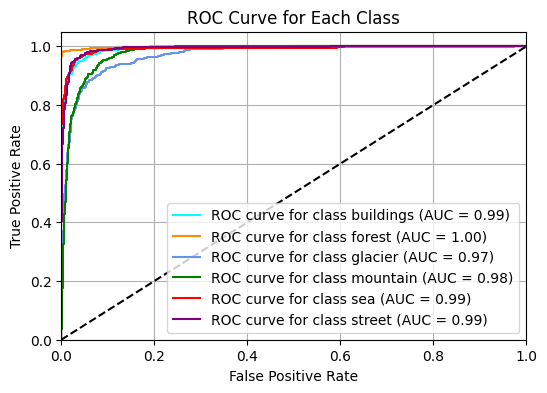

In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for ROC (one-vs-all)
y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(6, 4))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Loss Curve

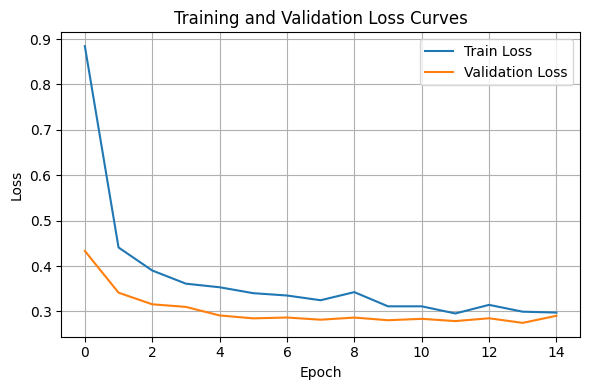

In [95]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
# ---- Tanh ----

In [81]:
# # Define the exact model setup using your original hyperparameters and logic

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import mobilenet_v2
# import gc

# # Define model using uploaded weights, no changes to hyperparameters or classifier
# class CustomMobileNetV2(nn.Module):
#     def __init__(self, num_classes, weights_path):
#         super().__init__()
#         base_model = mobilenet_v2(weights=None)
#         state_dict = torch.load(weights_path, map_location='cpu')
#         base_model.load_state_dict(state_dict)
#         for param in base_model.features.parameters():
#             param.requires_grad = False
#         self.features = base_model.features
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(base_model.last_channel, 128),
#             nn.Tanh(),  
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.mean([2, 3])  # Global average pooling
#         return self.classifier(x)

# # Train function exactly like your original setup
# def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15):
#     train_losses = []
#     val_losses = []
#     start_time = time.time()

#     for epoch in range(epochs):
#         gc.collect()
#         torch.cuda.empty_cache()

#         model.train()
#         total, correct, train_loss_sum = 0, 0, 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss_sum += loss.item()
#             _, preds = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (preds == labels).sum().item()

#         train_acc = 100 * correct / total
#         avg_train_loss = train_loss_sum / len(train_loader)

#         model.eval()
#         val_total, val_correct, val_loss_sum = 0, 0, 0.0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss_sum += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 val_total += labels.size(0)
#                 val_correct += (preds == labels).sum().item()

#         val_acc = 100 * val_correct / val_total
#         avg_val_loss = val_loss_sum / len(val_loader)

#         train_losses.append(avg_train_loss)
#         val_losses.append(avg_val_loss)

#         print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
#               f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

#     total_time = time.time() - start_time
#     print(f"\nTotal training time for MobileNetV2 with Tanh: {total_time:.2f} seconds")

#     return model, train_losses, val_losses


In [82]:
# # 1. Set paths and model
# weights_path = "/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth"  # ← change this to match your upload location
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CustomMobileNetV2(num_classes=6, weights_path=weights_path).to(device)

# # 2. Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# # 3. Train the model
# model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)


Epoch 01 | Train Loss: 0.8547 | Train Acc: 78.46% | Val Loss: 0.4679 | Val Acc: 86.89%
Epoch 02 | Train Loss: 0.4447 | Train Acc: 86.67% | Val Loss: 0.3774 | Val Acc: 87.95%
Epoch 03 | Train Loss: 0.3833 | Train Acc: 87.05% | Val Loss: 0.3373 | Val Acc: 88.70%
Epoch 04 | Train Loss: 0.3533 | Train Acc: 87.85% | Val Loss: 0.3249 | Val Acc: 89.17%
Epoch 05 | Train Loss: 0.3410 | Train Acc: 88.46% | Val Loss: 0.3111 | Val Acc: 88.74%
Epoch 06 | Train Loss: 0.3240 | Train Acc: 88.41% | Val Loss: 0.3110 | Val Acc: 89.13%
Epoch 07 | Train Loss: 0.3175 | Train Acc: 88.87% | Val Loss: 0.3086 | Val Acc: 89.02%
Epoch 08 | Train Loss: 0.3083 | Train Acc: 88.97% | Val Loss: 0.2993 | Val Acc: 89.52%
Epoch 09 | Train Loss: 0.3002 | Train Acc: 89.37% | Val Loss: 0.2998 | Val Acc: 89.31%
Epoch 10 | Train Loss: 0.2933 | Train Acc: 89.43% | Val Loss: 0.3037 | Val Acc: 89.17%
Epoch 11 | Train Loss: 0.2926 | Train Acc: 89.39% | Val Loss: 0.2967 | Val Acc: 89.42%
Epoch 12 | Train Loss: 0.2843 | Train Acc: 

In [96]:
# ==== NEW ====

# Define the exact model setup using your original hyperparameters and logic

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
import gc

# Define model using uploaded weights, no changes to hyperparameters or classifier
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, weights_path):
        super().__init__()
        base_model = mobilenet_v2(weights=None)
        state_dict = torch.load(weights_path, map_location='cpu')
        base_model.load_state_dict(state_dict)
        for param in base_model.features.parameters():
            param.requires_grad = False
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(base_model.last_channel, 128),
            nn.Tanh(),  # Replace with Tanh or Softsign for other experiments
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        return self.classifier(x)

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs=15):
    train_losses = []
    val_losses = []
    test_losses = []
    test_accuracies = []

    import time
    start_time = time.time()

    for epoch in range(epochs):
        gc.collect()
        torch.cuda.empty_cache()

        # === Training ===
        model.train()
        total, correct, train_loss_sum = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total
        avg_train_loss = train_loss_sum / len(train_loader)

        # === Validation ===
        model.eval()
        val_total, val_correct, val_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss_sum / len(val_loader)

        # === Test Evaluation ===
        test_total, test_correct, test_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (preds == labels).sum().item()

        test_acc = 100 * test_correct / test_total
        avg_test_loss = test_loss_sum / len(test_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)

        # === Print All Metrics Per Epoch ===
        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTotal training time for MobileNetV2 with ReLU: {total_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, test_accuracies




In [99]:
# 1. Set paths and model
weights_path = "/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth"  # adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomMobileNetV2(num_classes=6, weights_path=weights_path).to(device)

# 2. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# 3. Train the model (now with test evaluation)
model, train_losses, val_losses, test_losses, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, device)
# After training Tanh model
Tanh_train_losses = train_losses
Tanh_val_losses = val_losses

Epoch 01 | Train Loss: 0.8611 | Train Acc: 76.95% | Val Loss: 0.4559 | Val Acc: 88.74% | Test Loss: 0.4644 | Test Acc: 88.07%
Epoch 02 | Train Loss: 0.4577 | Train Acc: 85.90% | Val Loss: 0.3592 | Val Acc: 88.42% | Test Loss: 0.3632 | Test Acc: 88.43%
Epoch 03 | Train Loss: 0.3997 | Train Acc: 87.14% | Val Loss: 0.3133 | Val Acc: 89.99% | Test Loss: 0.3316 | Test Acc: 88.64%
Epoch 04 | Train Loss: 0.3623 | Train Acc: 87.71% | Val Loss: 0.2999 | Val Acc: 89.74% | Test Loss: 0.3234 | Test Acc: 88.85%
Epoch 05 | Train Loss: 0.3577 | Train Acc: 87.57% | Val Loss: 0.2923 | Val Acc: 89.59% | Test Loss: 0.3129 | Test Acc: 89.03%
Epoch 06 | Train Loss: 0.3328 | Train Acc: 88.18% | Val Loss: 0.2918 | Val Acc: 89.52% | Test Loss: 0.3042 | Test Acc: 89.35%
Epoch 07 | Train Loss: 0.3336 | Train Acc: 88.06% | Val Loss: 0.2887 | Val Acc: 89.45% | Test Loss: 0.3089 | Test Acc: 88.64%
Epoch 08 | Train Loss: 0.3105 | Train Acc: 89.10% | Val Loss: 0.2842 | Val Acc: 89.91% | Test Loss: 0.2971 | Test Acc:

In [100]:
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


In [ ]:
# classification_report

In [101]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df_Tanh = pd.DataFrame(report).transpose().round(2)
report_df_Tanh


precision  recall  f1-score  support
buildings          0.91    0.89      0.90   453.00
forest             0.98    0.98      0.98   441.00
glacier            0.81    0.84      0.82   474.00
mountain           0.86    0.81      0.83   526.00
sea                0.89    0.93      0.91   444.00
street             0.90    0.92      0.91   470.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.89    0.89      0.89  2808.00
weighted avg       0.89    0.89      0.89  2808.00

In [64]:
# ConfusionMatrix

<Figure size 800x600 with 0 Axes>

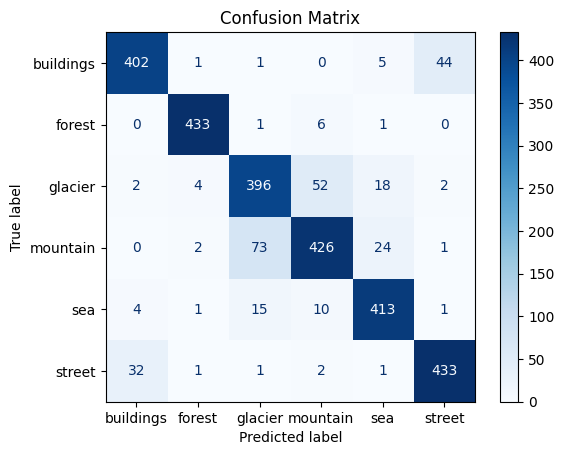

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ROC plot

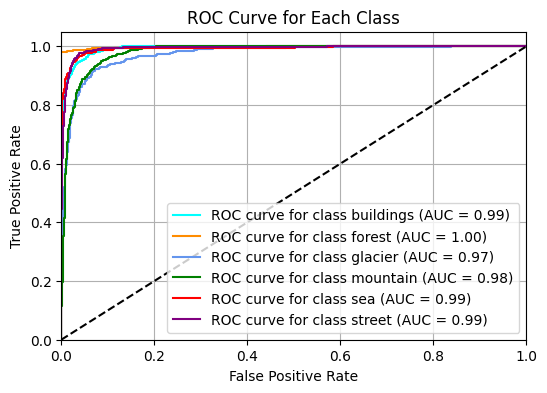

In [103]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for ROC (one-vs-all)
y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(6, 4))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Loss Curve

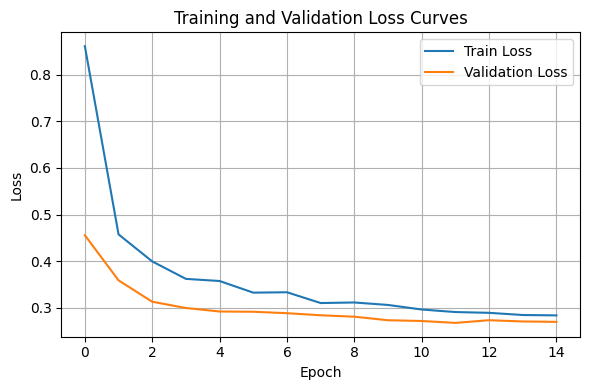

In [104]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Softsign ----

In [90]:
# # Define the exact model setup using your original hyperparameters and logic

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import mobilenet_v2
# import gc

# # Define model using uploaded weights, no changes to hyperparameters or classifier
# class CustomMobileNetV2(nn.Module):
#     def __init__(self, num_classes, weights_path):
#         super().__init__()
#         base_model = mobilenet_v2(weights=None)
#         state_dict = torch.load(weights_path, map_location='cpu')
#         base_model.load_state_dict(state_dict)
#         for param in base_model.features.parameters():
#             param.requires_grad = False
#         self.features = base_model.features
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(base_model.last_channel, 128),
#             nn.Softsign(), 
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.mean([2, 3])  # Global average pooling
#         return self.classifier(x)

# # Train function exactly like your original setup
# def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15):
#     train_losses = []
#     val_losses = []
#     start_time = time.time()

#     for epoch in range(epochs):
#         gc.collect()
#         torch.cuda.empty_cache()

#         model.train()
#         total, correct, train_loss_sum = 0, 0, 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss_sum += loss.item()
#             _, preds = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (preds == labels).sum().item()

#         train_acc = 100 * correct / total
#         avg_train_loss = train_loss_sum / len(train_loader)

#         model.eval()
#         val_total, val_correct, val_loss_sum = 0, 0, 0.0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss_sum += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 val_total += labels.size(0)
#                 val_correct += (preds == labels).sum().item()

#         val_acc = 100 * val_correct / val_total
#         avg_val_loss = val_loss_sum / len(val_loader)

#         train_losses.append(avg_train_loss)
#         val_losses.append(avg_val_loss)

#         print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
#               f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

#     total_time = time.time() - start_time
#     print(f"\nTotal training time for MobileNetV2 with Softsign: {total_time:.2f} seconds")

#     return model, train_losses, val_losses


In [91]:
# # 1. Set paths and model
# weights_path = "/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth"  # ← change this to match your upload location
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CustomMobileNetV2(num_classes=6, weights_path=weights_path).to(device)

# # 2. Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# # 3. Train the model
# model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)


Epoch 01 | Train Loss: 1.0049 | Train Acc: 76.47% | Val Loss: 0.5939 | Val Acc: 86.07%
Epoch 02 | Train Loss: 0.5268 | Train Acc: 86.35% | Val Loss: 0.4195 | Val Acc: 87.63%
Epoch 03 | Train Loss: 0.4255 | Train Acc: 86.78% | Val Loss: 0.3641 | Val Acc: 88.13%
Epoch 04 | Train Loss: 0.3768 | Train Acc: 87.83% | Val Loss: 0.3444 | Val Acc: 88.56%
Epoch 05 | Train Loss: 0.3544 | Train Acc: 87.90% | Val Loss: 0.3330 | Val Acc: 88.63%
Epoch 06 | Train Loss: 0.3423 | Train Acc: 88.00% | Val Loss: 0.3142 | Val Acc: 89.34%
Epoch 07 | Train Loss: 0.3321 | Train Acc: 88.63% | Val Loss: 0.3150 | Val Acc: 89.09%
Epoch 08 | Train Loss: 0.3192 | Train Acc: 88.79% | Val Loss: 0.3086 | Val Acc: 88.88%
Epoch 09 | Train Loss: 0.3153 | Train Acc: 89.11% | Val Loss: 0.3061 | Val Acc: 88.85%
Epoch 10 | Train Loss: 0.3035 | Train Acc: 89.28% | Val Loss: 0.3018 | Val Acc: 89.27%
Epoch 11 | Train Loss: 0.3010 | Train Acc: 89.06% | Val Loss: 0.2989 | Val Acc: 89.56%
Epoch 12 | Train Loss: 0.3026 | Train Acc: 

In [105]:
# ==== NEW ====

# Define the exact model setup using your original hyperparameters and logic

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
import gc

# Define model using uploaded weights, no changes to hyperparameters or classifier
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, weights_path):
        super().__init__()
        base_model = mobilenet_v2(weights=None)
        state_dict = torch.load(weights_path, map_location='cpu')
        base_model.load_state_dict(state_dict)
        for param in base_model.features.parameters():
            param.requires_grad = False
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(base_model.last_channel, 128),
            nn.Softsign(),  # Replace with Tanh or Softsign for other experiments
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        return self.classifier(x)

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs=15):
    train_losses = []
    val_losses = []
    test_losses = []
    test_accuracies = []

    import time
    start_time = time.time()

    for epoch in range(epochs):
        gc.collect()
        torch.cuda.empty_cache()

        # === Training ===
        model.train()
        total, correct, train_loss_sum = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total
        avg_train_loss = train_loss_sum / len(train_loader)

        # === Validation ===
        model.eval()
        val_total, val_correct, val_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss_sum / len(val_loader)

        # === Test Evaluation ===
        test_total, test_correct, test_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (preds == labels).sum().item()

        test_acc = 100 * test_correct / test_total
        avg_test_loss = test_loss_sum / len(test_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)

        # === Print All Metrics Per Epoch ===
        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTotal training time for MobileNetV2 with ReLU: {total_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, test_accuracies




In [106]:
# 1. Set paths and model
weights_path = "/kaggle/input/mobilenet_v2-b0353104/pytorch/default/1/mobilenet_v2-b0353104.pth"  # adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomMobileNetV2(num_classes=6, weights_path=weights_path).to(device)

# 2. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# 3. Train the model (now with test evaluation)
model, train_losses, val_losses, test_losses, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, device)

# After training Tanh model
Softsign_train_losses = train_losses
Softsign_val_losses = val_losses

Epoch 01 | Train Loss: 0.9896 | Train Acc: 76.98% | Val Loss: 0.5507 | Val Acc: 88.28% | Test Loss: 0.5606 | Test Acc: 87.64%
Epoch 02 | Train Loss: 0.5250 | Train Acc: 85.59% | Val Loss: 0.4021 | Val Acc: 88.56% | Test Loss: 0.4115 | Test Acc: 88.39%
Epoch 03 | Train Loss: 0.4253 | Train Acc: 86.54% | Val Loss: 0.3443 | Val Acc: 89.06% | Test Loss: 0.3547 | Test Acc: 88.64%
Epoch 04 | Train Loss: 0.3900 | Train Acc: 86.98% | Val Loss: 0.3189 | Val Acc: 89.20% | Test Loss: 0.3335 | Test Acc: 88.64%
Epoch 05 | Train Loss: 0.3631 | Train Acc: 87.54% | Val Loss: 0.3061 | Val Acc: 89.34% | Test Loss: 0.3187 | Test Acc: 88.71%
Epoch 06 | Train Loss: 0.3538 | Train Acc: 87.80% | Val Loss: 0.2981 | Val Acc: 89.84% | Test Loss: 0.3127 | Test Acc: 89.39%
Epoch 07 | Train Loss: 0.3394 | Train Acc: 87.90% | Val Loss: 0.2882 | Val Acc: 89.91% | Test Loss: 0.3050 | Test Acc: 89.17%
Epoch 08 | Train Loss: 0.3249 | Train Acc: 88.33% | Val Loss: 0.2831 | Val Acc: 90.09% | Test Loss: 0.3077 | Test Acc:

In [71]:
import numpy as np
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


In [109]:
from sklearn.metrics import classification_report
import pandas as pd

# If not already defined:
# class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df_Softsign = pd.DataFrame(report).transpose().round(2)
report_df_Softsign


precision  recall  f1-score  support
buildings          0.91    0.90      0.91    453.0
forest             0.98    0.98      0.98    441.0
glacier            0.82    0.84      0.83    474.0
mountain           0.86    0.81      0.84    526.0
sea                0.91    0.93      0.92    444.0
street             0.90    0.93      0.91    470.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.90    0.90      0.90   2808.0
weighted avg       0.90    0.90      0.90   2808.0

<Figure size 800x600 with 0 Axes>

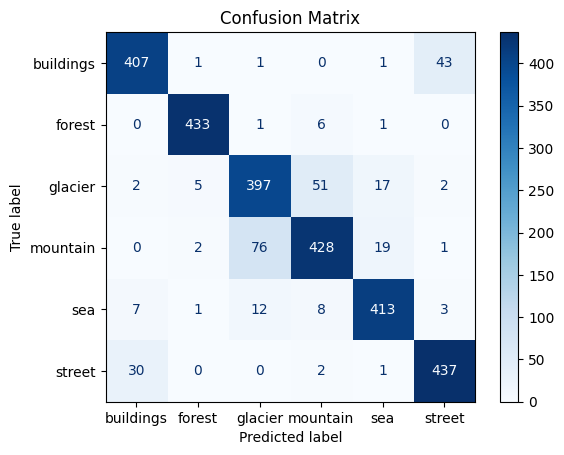

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


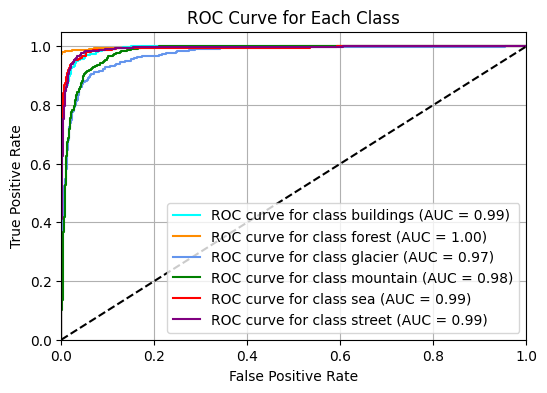

In [114]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for ROC (one-vs-all)
y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(6, 4))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


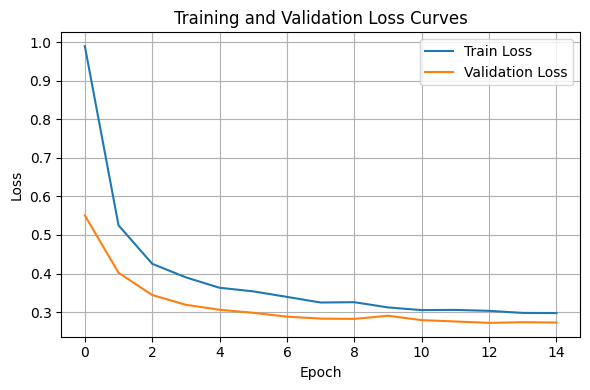

In [112]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


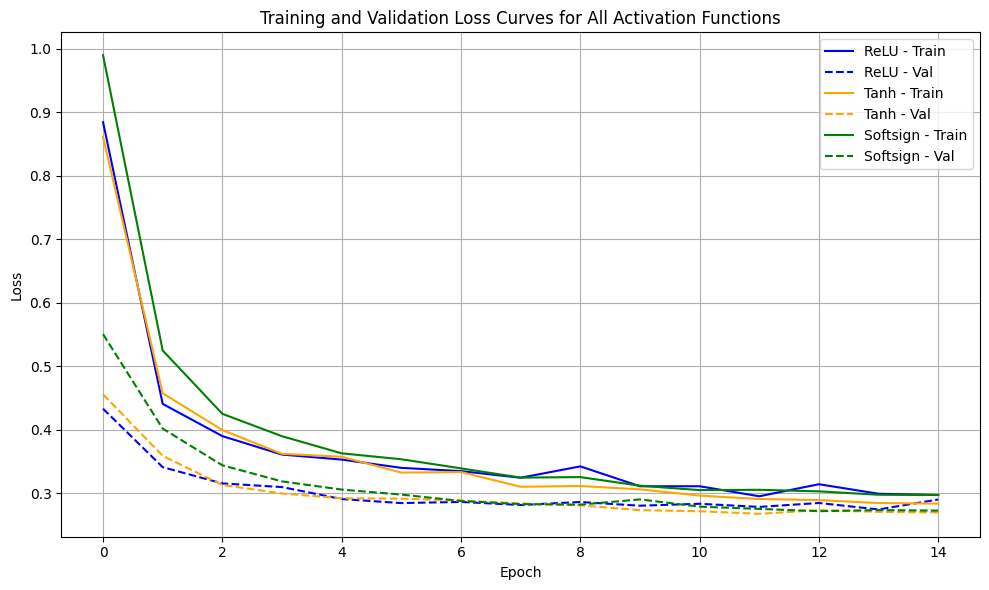

In [113]:
plt.figure(figsize=(10, 6))

# ReLU
plt.plot(Relu_train_losses, label="ReLU - Train", linestyle='-', c="blue")
plt.plot(Relu_val_losses, label="ReLU - Val", linestyle='--',c="blue")

# Tanh
plt.plot(Tanh_train_losses, label="Tanh - Train", linestyle='-', c="orange")
plt.plot(Tanh_val_losses, label="Tanh - Val", linestyle='--',c="orange")

# Softsign
plt.plot(Softsign_train_losses, label="Softsign - Train", linestyle='-', c="green")
plt.plot(Softsign_val_losses, label="Softsign - Val", linestyle='--', c="green")

plt.title("Training and Validation Loss Curves for All Activation Functions")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()